# **Modèles pour classification textuelle**

Une fois les données nettoyées dans le notebook `1. Preprocessing` précédent, nous allons maintenant utiliser plusieurs modèles pour tenter de classifier les messages.

# 1. Avant propos et méthodologie

## 1.1 Premiers éléments

Nous allons faire de la classification textuelle avec _overlapping_ de labels. Il s'agit donc d'une _multilabel classification_ par opposition au _multiclass classification_ dans le cas où un seul label était possible par message. Pour traiter cela nous allons tout simplement séparer l'analyse en deux _binary classification_ simples : prédiction d'être `label 1` puis prédiction d'être `label 8`. La prédiction d'être `label 1:8` sera alors la simple combinaison des deux exercices précédents.


Par ailleurs les labels sont équilibrés, à priori pas besoin d'utiliser les méthodes spécifiques au _imbalanced dataset_ (cf. `0. EDA.ipynb`)

## 1.2 Vectorisation des textes nettoyés

Afin de réaliser l'exercice en un temps raisonnable je me suis limité à prendre les modèles "sur étagère" largement connus et utilisés par la communauté plutôt que des algorithmes plus de niche/_state of the art_.

Le premier choix concerne l'implémentation d'un modèle transformant le texte nettoyé en un vecteur analysable par un algorithme de classification dans un second temps. Ces `vectorizers` retenus sont par ordre de complexité :
- (Non implémenté) One-Hot Vectorize/Bag of Words
- TF-IDF : une matrice _document term_ de même taille que précédemment mais mieux pondérée, amélioration immédiate de la méthode précédente
- Embedding statique _a la_ word2vec : moyenne arithmétique des word2vec pour faire un Doc2Vec
- (Non implémenté) Combinaison des deux méthodes pour faire du doc/sent2vec où les pondérations par mot sont données par le TF-IDF
- Embedding "dynamique" en ayant recours à un transformers (partie encoder), ici camembert (BERT français)

## 1.3 Algorithmes de ML pour classification supervisée

Une fois la représentation vectorielle plus ou moins dense retenue, il faut recourir un à algorithme de classification classique du machine learning. Pour en citer quelques-uns :
- Régression logistique simple ou pénalisée (Ridge, Lasso)
- SVM, particulièrement efficace pour des tâches de classification textuelle dans la mesure où elle prend efficacement en compte les matrices _sparses_ de TF-IDF
- XGBoost : "roi des compétitions Kaggle"

Ces modèles peuvent chacun faire l'objet d'une _hyperparameter tuning_ pour améliorer les performances.

## 1.4 Métriques de succès

Puisque l'échantillon est quasi équilibré entre 1 et 8 (même lorsque qu'on attribue `1:8` à l'une ou l'autre des classes) l'accuracy toute simple pourrait être suffisante, alors que cette métrique est très peu utilisée usuellement (absolument pas pertinente dès lors que l'échantillon est déséquilibré, ce qui est généralement le cas en pratique - en tout cas dans mon expérience passée).

# 2. Packages usuels et importation

In [1]:
# Pour faciliter la mise à jour des fonctions écrites dans func_custom sans avoir à redémarrer le kernel
%load_ext autoreload
%autoreload 2

In [2]:
# Packages classiques
import pandas as pd
import torch

# NLP
import spacy
from transformers import CamembertModel, CamembertTokenizer


# Machine Learning
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

c:\Users\TitouanBlaize\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\TitouanBlaize\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
df = pd.read_csv("data/data_clean_lemmetized.csv", sep = ";")

In [4]:
# Préparation des labels pour transformer la classification multilabel en deux classifications binaires classiques
df["label_1"] = df["label"].apply(lambda x : "1" in x)
df["label_8"] = df["label"].apply(lambda x : "8" in x)
y_1 = df["label_1"]
y_8 = df["label_8"]

In [5]:
# Illustration avec pour le moment classification des 1
y = y_1

my_random = 29570
my_size = 0.2

# 3. Comparaison des modèles de vectorisation

## 3.1 TF_IDF

L'approche "Bag of Word" (un one hot encoder des mots du vocabulaire) n'est pas montrée car le TF_IDF est une amélioration immédiation où au lieu d'avoir des simples 1 dans la matrice, les poids de chaque mots dans la phrase sont pondérés par un critère d'importance. La taille de la matrice reste cependnat la même.

In [6]:
messages = df["message_clean"]

# Si on voulait comparer les résultats en prenant des messages non nettoyés
# messages = df["message"].apply(lambda x: unicodedata.normalize("NFKC", x))

In [7]:
vectorizer = TfidfVectorizer(min_df = 2)
X = vectorizer.fit_transform(messages)

In [8]:
# Pour illustrer la vectorisation de TF-IDF
pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out()).head()

,abattement,abord,aboutir,absence,absolument,accepter,accessible,accident,accompagner,accord,...,étudiant,évaluer,éventuel,éventuellement,évidemment,évident,éviter,évoluer,évolution,événement
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171383
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [9]:
print(f"On constate que le dictionnaire du TF-IDF est de {X.shape[1]} features")

On constate que le dictionnaire du TF-IDF est de 1479 features


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = my_size,
                                                    random_state = my_random)

classifier = LinearSVC()
# D'autres algos de ML possibles, par exemple si XGBoost
# classifier = xgb.XGBClassifier()

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
report = classification_report(y_test, y_pred)

In [11]:
print(report)

              precision    recall  f1-score   support

       False       0.82      0.69      0.75        68
        True       0.75      0.86      0.80        72

    accuracy                           0.78       140
   macro avg       0.79      0.78      0.78       140
weighted avg       0.78      0.78      0.78       140



Le F1-score (de la cible) est de 84%, ce qui peut sembler à priori satisfaisant pour un entraînement sur petit échantillon.

In [12]:
# Code "à la main" pour créer la visualisation des plus grandes contributions

coef = classifier.coef_[0]
vocabulary_positions = coef.argsort()
vocabulary = vectorizer.get_feature_names_out()

top_words = 10
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

df_contrib = pd.DataFrame([[vocabulary[c], coef[c]] for c in top_positive_coef + top_negative_coef], 
                          columns = ["feature", "coefficient"]).sort_values("coefficient")

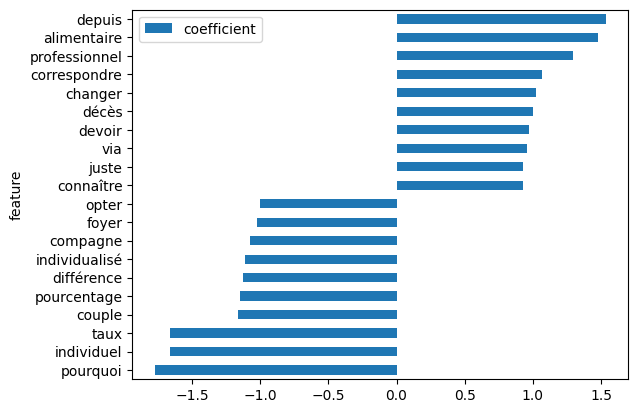

In [13]:
_ = df_contrib.set_index("feature").plot.barh()

**Que représentent les labels ?**

Analyse des messages me laisse entendre que la distinction entre 1 et 8 n'est pas "topic related" mais plutôt sur la teneur de demande :
- Les 1 sont de simples demandes d'aide, notamment sur l'interface, pour effectuer un changement de taux, signaler un changement de situation ("depuis" indique souvent que la personne indique un changement de situation "depuis", de même pour "suite")
- Les 8 sont à l'inverse des plaintes, la situation constatée par le contribuable ne correspond pas à l'attendu et il souhaite une explication.

In [14]:
# En utilisant XGBoost cela aurait permit aussi une visualisation intégrée

# _ = xgb.plot_importance(classifier, 
#                         importance_type = "gain",
#                         max_num_features = 25,
#                         show_values = False)

## 3.2 Doc2Vec : Word2Vec issu de Spacy + moyenne arithmétique

Les messages adressés par les contribuables sont rédigés dans une langue orale/écrite courante et **ne présente pas de termes techniques/jargon spécifique**. Un embedding entraîné sur un corpus usuel sera donc suffisant pour ne pas entraîner de problème de dictionnaire. J'ai retenu par simplicité d'utilisation celui présent sur Spacy. Par économie de taille On peut retenir le "medium", dans l'espoir d'avoir les meilleurs résultats possibles j'importe le "large".

In [15]:
nlp = spacy.load("fr_core_news_lg")

In [16]:
df_spacy = df.copy()

In [17]:
df_spacy["embedding_avg"] = df_spacy["message_clean"].apply(lambda x: nlp(x).vector) 

`doc.vector` donne l'embedding par moyenne arithmétique des mots de la phrase

Stratégie pas très pertinente pour un long message, mais retenue par simplicité d'utilisation. On pourrait repondérer par les poids du TF-IDF. On anticipe cependant des résultats pas très satisfaisants pour des longues sequences.

In [18]:
df_embedding = pd.DataFrame()
for elem in df_spacy["embedding_avg"]:
    temp = (pd.DataFrame((elem)).T)
    df_embedding = pd.concat([df_embedding, temp])

# df_embedding.to_csv("data_spacy.csv", sep = ";", index = False)

In [19]:
print(f"On passe des {X.shape[1]} features du TF-IDF à {df_embedding.shape[1]} features ici")

On passe des 1479 features du TF-IDF à 300 features ici


In [20]:
X = df_embedding

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = my_size,
                                                    random_state = my_random)

classifier = LinearSVC()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
report = classification_report(y_test, y_pred)

In [21]:
print(report)

              precision    recall  f1-score   support

       False       0.75      0.72      0.74        68
        True       0.75      0.78      0.76        72

    accuracy                           0.75       140
   macro avg       0.75      0.75      0.75       140
weighted avg       0.75      0.75      0.75       140



Comme attendu les performances sont bien plus décevantes, on moyennise brutallement une longue phrase en prenant la moyenne arithmétique des embedding de chaque mot, il est très peu probablement que la moyenne non pondérée donne quelque chose de pertinent au niveau de la phrase entière.

## 3.3 Transformers : Camembert (RoBERTa)

Nous allons avoir recours à des transfomers et plus particulièrement ceux présentant uniquement la partie encodage de façon à avoir une réprenstation dense de la phrase. Il s'agit donc des modèles BERT (au lieu des GPT génératifs). Classiquement j'ai recours à HuggingFace pour utiliser facilement des modèles pré-entraînés, et notamment ici [CamemBERT](https://huggingface.co/almanach/camembert-base)

On aurait également pu passer par Spacy qui dispose d'une façon simple d'implémenter un transformers français https://spacy.io/models/fr#fr_dep_news_trf

J'utilise ici une méthode simple plutôt qu'un fine-tuning PyTorch (https://camembert-model.fr/posts/tutorial_part2/) : je garde figé tous les paramètres du modèles pour n'utiliser que les embeddings en sortie de Camembert comme input d'une simple classification ML.

In [22]:
# You can replace "camembert-base" with any other model from the table, e.g. "camembert/camembert-large".
tokenizer = CamembertTokenizer.from_pretrained("camembert/camembert-base-wikipedia-4gb")
camembert = CamembertModel.from_pretrained("camembert/camembert-base-wikipedia-4gb")

c:\Users\TitouanBlaize\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [23]:
to_run = False

if to_run :
    # Méthode à la main pour récupérer les embeddings de la dernière couche de CamemBERT et constituer la dataframe X utile à l'algo de ML

    df_camembert  = pd.DataFrame()
    for index, row in df.iterrows():
        message_raw = row["message"]

        tokenized_sentence = tokenizer.tokenize(message_raw)

        encoded_sentence = tokenizer.encode(tokenized_sentence)

        # Par simplicité je coupe au maximum du "maximum context size" de CamemBERT
        # Possibilité d'itérer sur des batch de 512 jusqu'à avoir tout le texte puis de moyenniser
        if (len(encoded_sentence) > 512) :
            encoded_sentence = encoded_sentence[:511]
            
        encoded_sentence = torch.tensor(encoded_sentence).unsqueeze(0)

        results_camembert = camembert(encoded_sentence)

        # last_hidden_state.detach() permet d'aller chercher la dernière couche de CamemBERT
        # [:,0,:] pour prendre le premier token [CLS] qui contient toute l'information de la phrase
        new_row = pd.DataFrame(results_camembert.last_hidden_state.detach()[:,0,:])
        df_camembert = pd.concat([df_camembert, new_row], ignore_index = True)

    # Sauvegarde pour gagner du temps
    df_camembert.to_csv("data/data_camembert.csv", sep = ";", index = False)
else :
    df_camembert = pd.read_csv("data/data_camembert.csv", sep = ";")

In [24]:
X = df_camembert

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = my_size,
                                                    random_state = my_random)

classifier = LogisticRegression()
classifier = LinearSVC()
# classifier = xgb.XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
report = classification_report(y_test, y_pred)

In [25]:
print(report)

              precision    recall  f1-score   support

       False       0.81      0.75      0.78        68
        True       0.78      0.83      0.81        72

    accuracy                           0.79       140
   macro avg       0.79      0.79      0.79       140
weighted avg       0.79      0.79      0.79       140



# 4. Optimisation par RandomizedSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, loguniform

param_dist = {
    'C': loguniform(1e-3, 1e3),  # Regularization parameter (log-uniform distribution)
    'loss': ['hinge', 'squared_hinge'],  # Loss function
}

random_search = RandomizedSearchCV(classifier, 
                                   param_distributions = param_dist, 
                                   n_iter = 50, 
                                   cv = 5, 
                                   scoring = 'f1', 
                                   random_state = my_random)


random_search.fit(X, y)

print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

best_model = random_search.best_estimator_
predictions = best_model.predict(X)

# Best "C" is 0.8

# 5. Combinaison des deux classifications binaires pour créer résultats